# Gas Predict

Predict gas fees for the next X hours to be able to judge how likely certain lows are going to happen.

We're especially interested in predicting the next low gas fees as well as their probabilities.

To download the data, we use `run-download.sh`.

### Read Data

In [1]:
import json

data_file = "data/data.json"

with open(data_file,"r") as f:
    data_json = json.load(f)

434100 blocks


In [6]:
import numpy as np

In [12]:
# Convert to a format where we have an array with fields:
# blocknr, day in week, hour in day, minute in hour, second in minute

# Essentially, given a few days of gas prices, we want to predict how it's going to continue.

# we change from each block = 12 seconds to
# each 5-minute time-span à 25 blocks = 300 seconds

oN = len(data_json)
print(oN,"blocks")

compressed = True
compression_factor = 25

M = 7
# fields: blockr, gas, timestamp, median over window, minimum over window, 15%-quantile over window, 15%-quantile over past window
# each block will be centered in its window and not preceding it. this is, because we want all these
# rolling averages to have the spikes etc. on the same block
window_size = 6 if compressed else 30*60//12 # x minutes = x*60 seconds = x*60/12 blocks
odata = np.zeros((oN, M),dtype=np.int64)

i = 0
for k, v in data_json.items():
    fee = v["fee"]
    odata[i] = np.array([k,int(fee), v["t"], fee, fee, fee, fee],dtype=np.int64)
    i = i + 1
    
# sort by time (newest last)
odata = odata[odata[:,0].argsort()]

print("Compressing...")
ndata = np.zeros((oN // compression_factor, M), dtype=np.int64)
for i in range(oN // compression_factor):
    ndata[i] = np.min(odata[(i*compression_factor):((i+1)*compression_factor)],axis=0)

oN = oN // compression_factor
odata = ndata


print("Calculating rolling windows...")
for i in range(oN):
    if i < window_size:
        continue
    m = i - window_size + window_size // 2
    odata[m,3] = np.median(odata[(i-window_size):i,1])
    odata[m,4] = np.min(odata[(i-window_size):i,1])
    odata[m,5] = np.quantile(odata[(i-window_size):i,1], 0.15)
    
    # live computable quantile
    odata[i,6] = np.quantile(odata[(i-window_size):i,1], 0.15)
    
print("Done.")
    
print(odata[:12])
print(odata[(oN-12):])

434100 blocks
Compressing...
Calculating rolling windows...
Done.
[[  16565722         16 1675637963         16         16         16
          16]
 [  16565747         16 1675638263         16         16         16
          16]
 [  16565772         15 1675638563         15         15         15
          15]
 [  16565797         16 1675638875         15         14         14
          16]
 [  16565822         15 1675639175         15         14         14
          15]
 [  16565847         14 1675639475         15         14         14
          14]
 [  16565872         14 1675639775         15         14         14
          14]
 [  16565897         15 1675640075         15         14         14
          14]
 [  16565922         16 1675640387         14         14         14
          14]
 [  16565947         15 1675640699         15         14         14
          14]
 [  16565972         14 1675640999         15         14         14
          14]
 [  16565997         15 16756412

Rather than predicting the gas price, it makes more sense to create moving median, minimum and x quantile (e.g. 15%%) and predict that.
Otherwise the high spikes in gas price will dominate the predictions even though we're rather interested in the lows.

---

## Gas Price with moving median/minimun/quantile(15%)

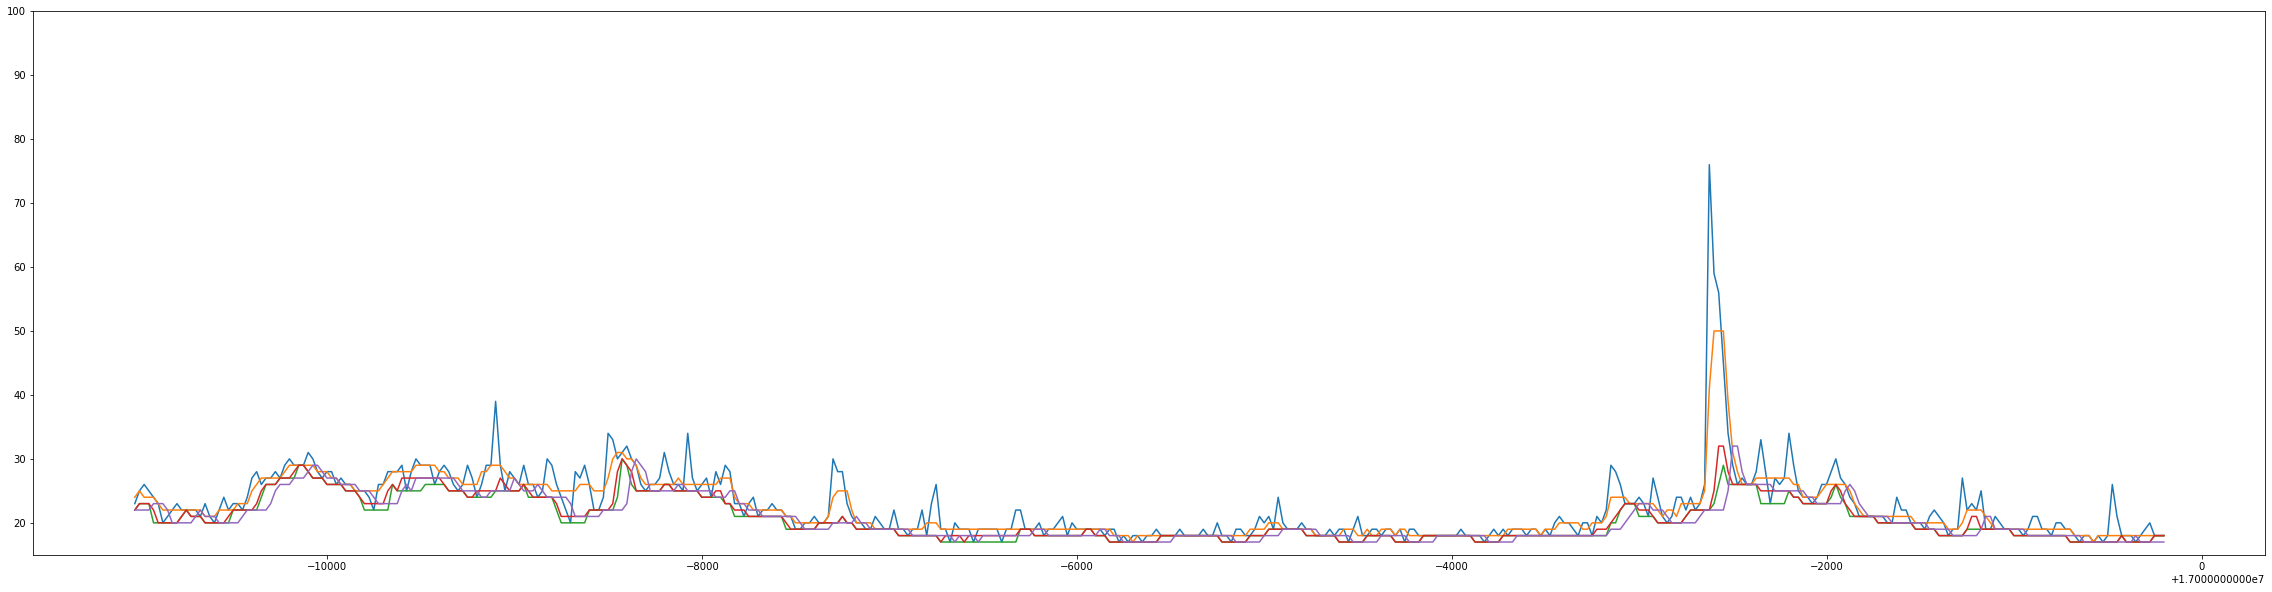

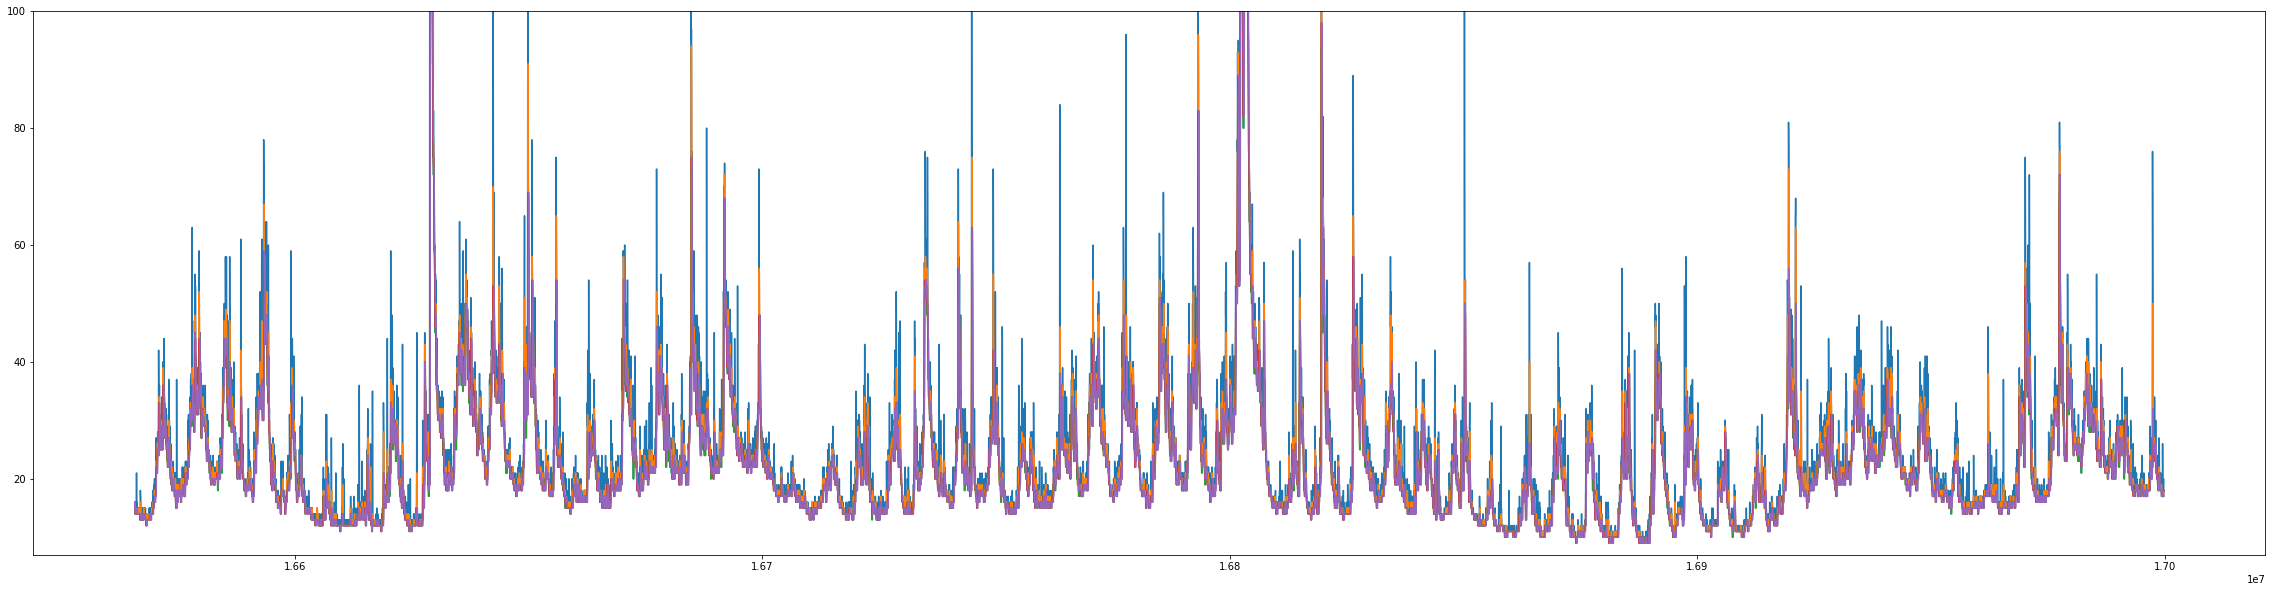

In [13]:
import matplotlib.pyplot as plt

showN = oN // 40

plt.figure(figsize=(40,10))
plt.plot(odata[-showN:,0],odata[-showN:,1])
plt.plot(odata[-showN:,0],odata[-showN:,3])
plt.plot(odata[-showN:,0],odata[-showN:,4])
plt.plot(odata[-showN:,0],odata[-showN:,5])
plt.plot(odata[-showN:,0],odata[-showN:,6])
plt.ylim(15,100)
plt.show()

showN = oN

plt.figure(figsize=(40,10))
plt.plot(odata[-showN:,0],odata[-showN:,1])
plt.plot(odata[-showN:,0],odata[-showN:,3])
plt.plot(odata[-showN:,0],odata[-showN:,4])
plt.plot(odata[-showN:,0],odata[-showN:,5])
plt.plot(odata[-showN:,0],odata[-showN:,6])
plt.ylim(7,100)
plt.show()


In [14]:
%matplotlib inline

## Forcasting

Used this tutorial/template:
https://www.cienciadedatos.net/documentos/py27-time-series-forecasting-python-scikitlearn.html

PYAF: https://towardsdatascience.com/3-unique-python-packages-for-time-series-forecasting-2926a09aaf5b


In [15]:
import pandas as pd

# Plots
# ==============================================================================
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
%matplotlib inline

# Modeling and Forecasting
# ==============================================================================
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregDirect import ForecasterAutoregDirect
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster
from skforecast.utils import save_forecaster
from skforecast.utils import load_forecaster

# ================================
import pyaf.ForecastEngine as auto

from mlforecast import MLForecast
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR

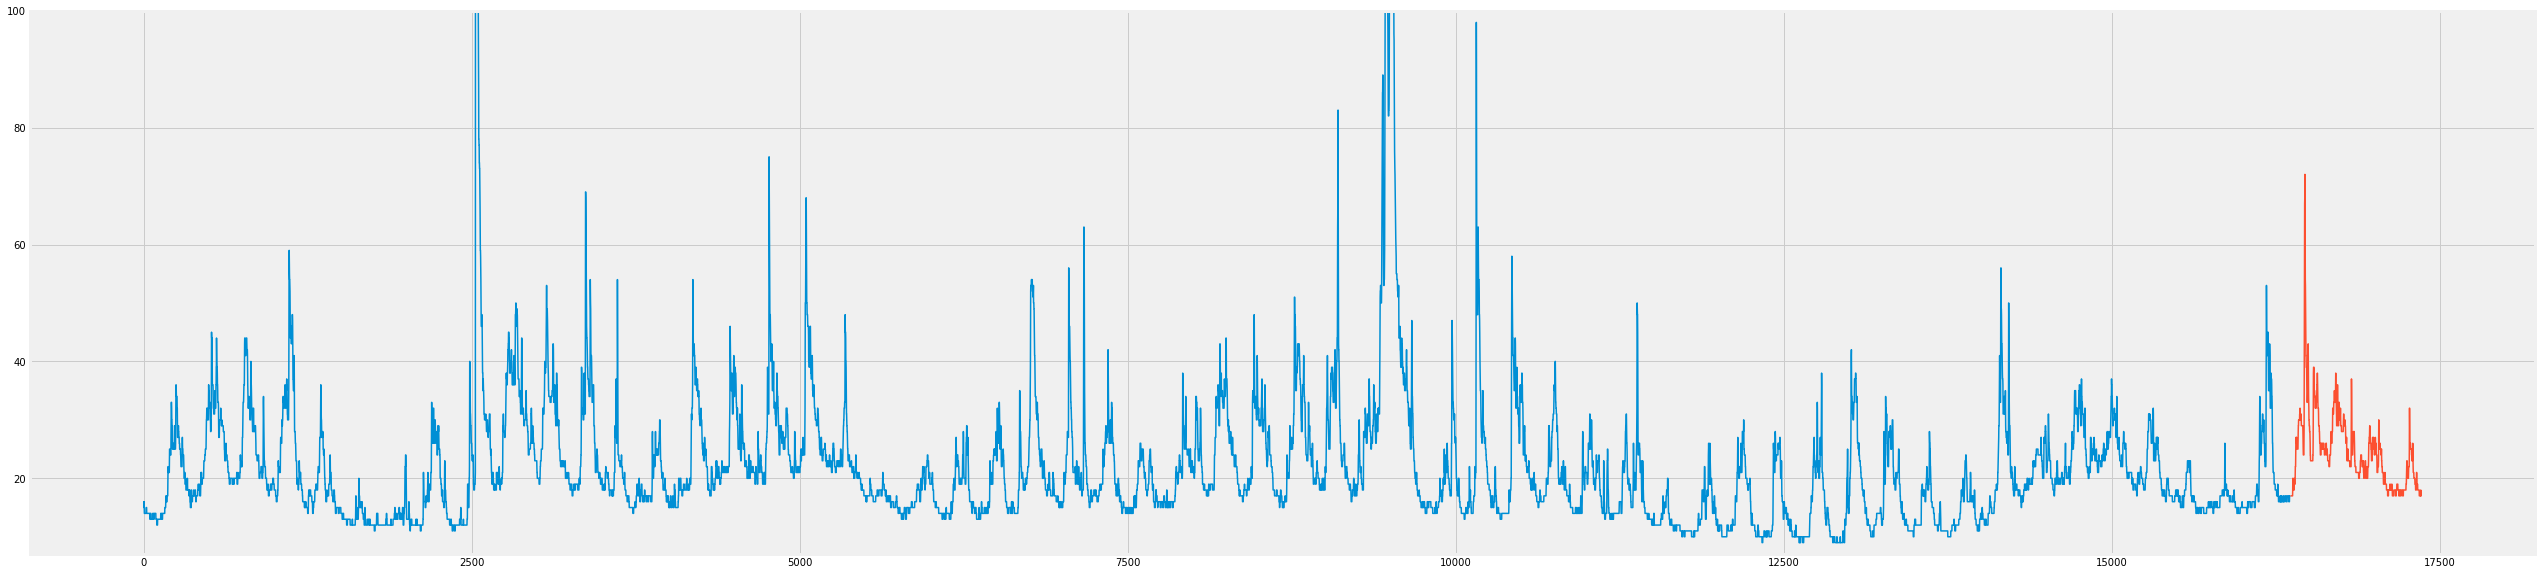

In [52]:
# test train split

nBlockTest = 1000
skip = 0 # 100000
oNt = oN - skip

data_train = pd.DataFrame(odata[skip:-nBlockTest, [0,1,6]]) # keep only mid-window-quantile and live-quantile
data_test  = pd.DataFrame(odata[-nBlockTest:, [0,1,6]])
cols = ["BlockNr", "Gas","Live-Quantile"] # , "Median", "Minimum"
xVar = "Live-Quantile"
yVar = "Live-Quantile"
data_train.columns = cols
data_test.columns = cols


plt.figure(figsize=(40,10))
plt.plot(np.arange(oNt-nBlockTest),data_train[xVar])
plt.plot(np.arange(nBlockTest)+(oNt-nBlockTest),data_test[xVar])
plt.ylim(7,100)
plt.show()

In [53]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16364 entries, 0 to 16363
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   BlockNr        16364 non-null  int64
 1   Gas            16364 non-null  int64
 2   Live-Quantile  16364 non-null  int64
dtypes: int64(3)
memory usage: 383.7 KB


In [54]:
data_train.head()

,BlockNr,Gas,Live-Quantile
0,16565722,16,16
1,16565747,16,16
2,16565772,15,15
3,16565797,16,16
4,16565822,15,15


In [55]:
models = ["firecasterautoreg", "pyaf", "mlforecast"]

model = models[2]

day = 7200 // compression_factor if compressed else 7200

pred_past_window = 10000
nDays = 0 # 7
pred_forward_steps = 1000

if model == models[0]:

    forecaster = ForecasterAutoreg(
        regressor = RandomForestRegressor(random_state=1337),
        lags=pred_past_window
    )

    forecaster.fit(y=data_train[yVar])
    print(forecaster)
    
elif model == models[1]:
    lEngine = autof.cForecastEngine()# get the best time series model for test prediction
    lEngine.train(iInputDS = data_train, iTime = "BlockNr", iSignal = yVar, iHorizon = pred_forward_steps)
    
elif model == models[2]:
    forecaster = MLForecast(
        models=LinearRegression(),
        freq=1, # 1 because each block follows the previous one
        lags=[i*day for i in range(1,nDays+1)], # lag of 1 - nDays days
        # differences=[day],
        num_threads = 3,
    )
    data_train["id"] = data_train["BlockNr"] # need different columns as id and time for mlforecast
    forecaster.fit(data_train, id_col = "id", time_col = "BlockNr", target_col = yVar)
    print(forecaster)
else:
    raise ValueError

MLForecast(models=[LinearRegression], freq=1, lag_features=[], date_features=[], num_threads=3)


In [69]:
steps = 1000

if model == models[0]:
    predictions = forecaster.predict(steps=steps)
elif model == models[1]:
    predictions = lEngine.forecast(data_test.tail(pred_forward_steps),pred_forward_steps)
elif model == models[2]:
    data_test_2 = data_test.copy()
    data_test_2 = data_test_2.tail(1000 // compression_factor)
    data_test_2["id"] = data_test_2["BlockNr"]
    predictions = forecaster.predict(steps, new_data=data_test_2)

predictions.head(5)

,id,BlockNr,LinearRegression
0,16998822,16998823,22.388949
1,16998822,16998824,22.388949
2,16998822,16998825,22.388949
3,16998822,16998826,22.388949
4,16998822,16998827,22.388949


In [70]:
predictions.info()
# why does this have such a weird length?

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                40000 non-null  int64  
 1   BlockNr           40000 non-null  int64  
 2   LinearRegression  40000 non-null  float64
dtypes: float64(1), int64(2)
memory usage: 937.6 KB


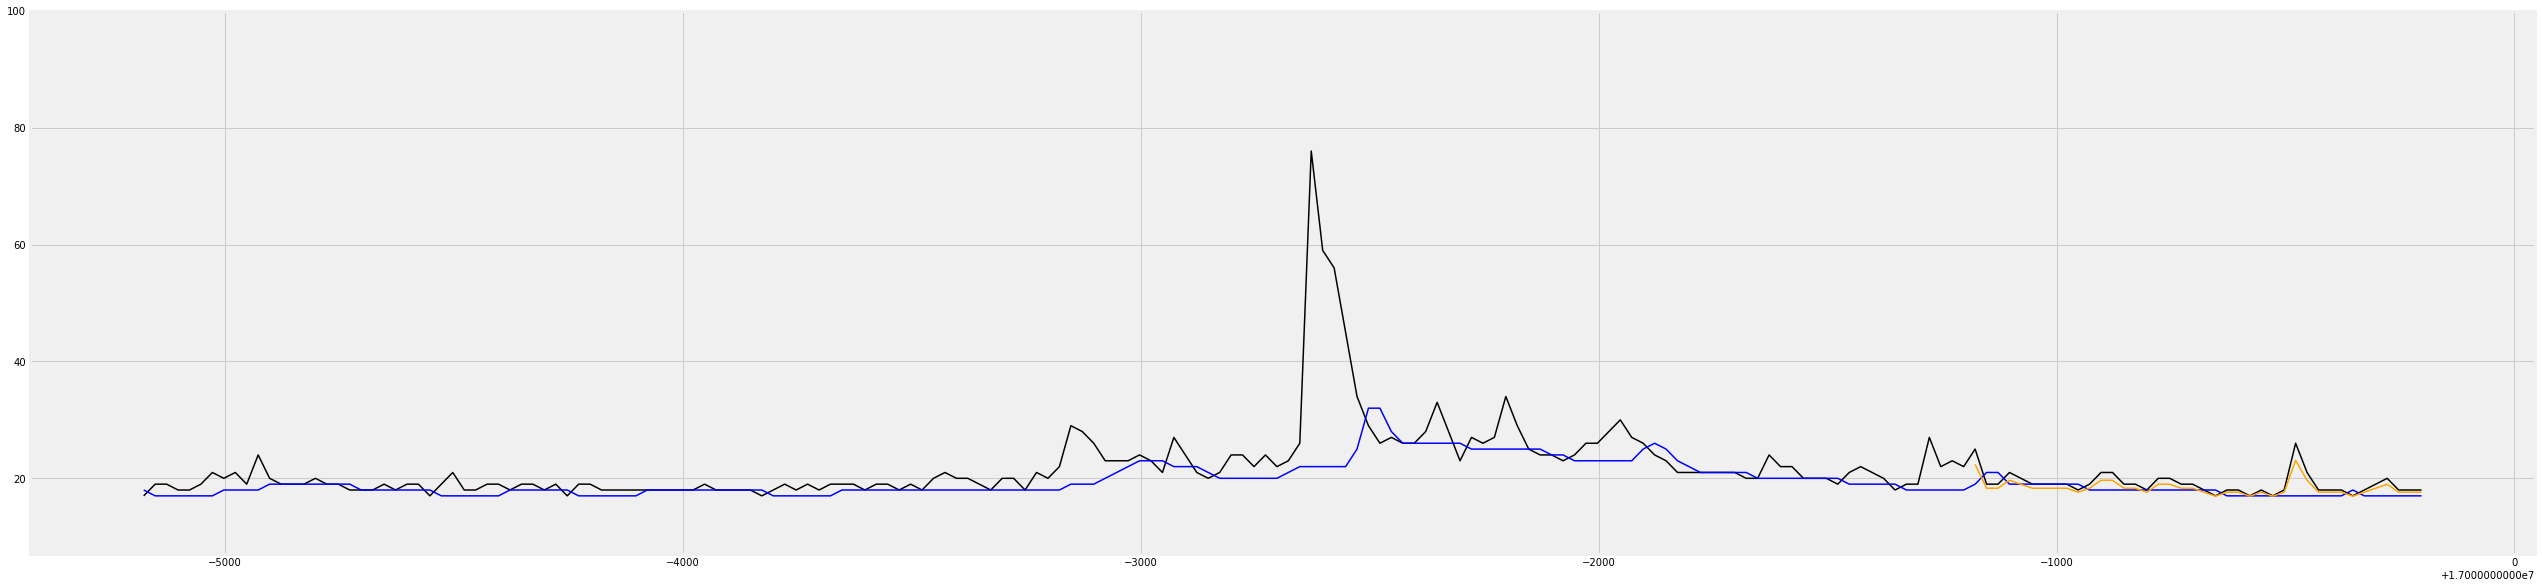

In [71]:
plt.figure(figsize=(40,10))
# plt.plot(np.arange(oNt-nBlockTest),data_train[xVar],"b")
plt.plot(data_test.tail(5000 // compression_factor)["BlockNr"],data_test.tail(5000 // compression_factor)["Gas"],"black")#
plt.plot(data_test.tail(5000 // compression_factor)["BlockNr"],data_test.tail(5000 // compression_factor)["Live-Quantile"],"blue")#
plt.plot(predictions["id"],predictions["LinearRegression"],"orange")
plt.ylim(7,100)
plt.show()

## ^ Predictions are not sensible. It seems to actually predict the same thing as it reads... Is it actually predicting something??